In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))
 
#여백 줄이기
display(HTML("<style>.prompt { min-width: 1ex !important; }</style>"))
 
#In 부분 없애기
#display(HTML("<style>.prompt bdi { display:none !important; }</style>"))
 
#아예 다 없애기
#display(HTML("<style>.prompt { display:none !important; }</style>"))

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("ggplot")

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 10)

# Data Load
---

In [5]:
import os
os.getcwd()

'c:\\Users\\Leechoongsung\\Desktop\\INDEX\\Lpoint_competition\\domain_clustering'

In [4]:
df_cust = pd.read_csv("../../LPOINT_BIG_COMP/LPOINT_BIG_COMP_01_DEMO.csv")
df_pdde = pd.read_csv("../../LPOINT_BIG_COMP/LPOINT_BIG_COMP_02_PDDE.csv")
df_cop_u = pd.read_csv("../../LPOINT_BIG_COMP/LPOINT_BIG_COMP_03_COP_U.csv")
df_pd_clac = pd.read_csv("../../LPOINT_BIG_COMP/LPOINT_BIG_COMP_04_PD_CLAC.csv")
# df_cust = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_01_DEMO.csv")
# df_pdde = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_02_PDDE.csv")

c:\Users\Leechoongsung\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# 함수화
---

In [5]:
# 누락 데이터 삭제
def check_on_off(df_main, df, key="cust", col_nm="chnl_dv"):
    df_new = pd.DataFrame(df.groupby(key)[col_nm].apply(lambda x:list(set(x))))
    return df_main.merge(df_new, how="left", on=key).dropna(subset=["chnl_dv"])

# on/off 분류
def split_on_off(df, col_nm="chnl_dv"):
    df[col_nm] = df[col_nm].apply(lambda x: x[0] if len(x)==1 else 0)
    df_res1 = df.loc[df[col_nm]==1] ##off
    df_res2 = df.loc[df[col_nm]==2] ##on
    df_res3 = df.loc[df[col_nm]==0] ##onf
    return df_res1, df_res2, df_res3 #off, on, onf

# loyal/unloyal 분류
def split_loyal(df_main, df_sub, col_nm ='rct_no', key = 'cust'):
    df_rct_no = pd.DataFrame(df_sub.groupby([key])[col_nm].apply(lambda x: len(list(set(x))))).reset_index()
    df_m2 = df_main.merge(df_rct_no, how="left", on=key)
    df_loyal = df_m2.loc[df_m2[col_nm]>3]
    df_unloyal = df_m2.loc[df_m2[col_nm]<=3]
    return df_loyal, df_unloyal

# vip/unvip 분류
def split_vip(df_main, df_sub, col_nm='buy_am', key='cust'):
    df_buy_am = pd.DataFrame(df_sub.groupby([key],as_index=False)[col_nm].sum())
    df_m2 = df_main.merge(df_buy_am, how='left', on=key)
    df_vip = df_m2.loc[df_m2[col_nm]>200000]
    df_unvip = df_m2.loc[df_m2[col_nm]<=200000]
    return df_vip, df_unvip

##unloyal Nan 문제 해결
def unloyal_buy_am_solve(df_main, df_sub, col_nm='buy_am', key='cust'):
    df_buy_am = pd.DataFrame(df_sub.groupby([key],as_index=False)[col_nm].sum())
    df_m2 = df_main.merge(df_buy_am, how='left', on=key)
    return df_m2


def domain_clustering(df_main, df_sub):
    df = check_on_off(df_main, df_sub)

    df_off, df_on, df_onf = split_on_off(df)

    df_01, df_2 = split_loyal(df_on, df_sub)
    df_34, df_5 = split_loyal(df_onf, df_sub)
    df_67, df_8 = split_loyal(df_off, df_sub)

    df_0, df_1 = split_vip(df_01, df_sub)
    df_3, df_4 = split_vip(df_34, df_sub)
    df_6, df_7 = split_vip(df_67, df_sub)
    
    df_2 = unloyal_buy_am_solve(df_2, df_sub)
    df_5 = unloyal_buy_am_solve(df_5, df_sub)
    df_8 = unloyal_buy_am_solve(df_8, df_sub)
    
    df_init = pd.DataFrame()
    for i, df_temp in enumerate([df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8]):
        df_temp["cluster"] = i
        df_init = pd.concat([df_init, df_temp], axis=0, ignore_index=True)
        
    return df_init


In [6]:
result = domain_clustering(df_cust, df_pdde)

In [7]:
result

,cust,ma_fem_dv,ages,zon_hlv,chnl_dv,rct_no,buy_am,cluster
0,M001248380,여성,30대,Z10,2,38,992100.0,0
1,M006962764,남성,30대,Z17,2,35,1085730.0,0
2,M008864908,남성,30대,Z04,2,22,968700.0,0
3,M014792007,여성,30대,Z13,2,4,735200.0,0
4,M021341630,여성,40대,Z07,2,23,2718870.0,0
...,...,...,...,...,...,...,...,...
26912,M996092967,여성,60대,Z16,1,3,349000.0,8
26913,M996679486,여성,40대,Z16,1,2,14180.0,8
26914,M997482914,여성,40대,Z03,1,2,64000.0,8
26915,M999340261,남성,50대,Z11,1,3,3468000.0,8


In [8]:
result[['cust', 'cluster']].to_csv('domain_cluster_result.csv', index=False)

In [9]:
result[['cust', 'cluster']]

,cust,cluster
0,M001248380,0
1,M006962764,0
2,M008864908,0
3,M014792007,0
4,M021341630,0
...,...,...
26912,M996092967,8
26913,M996679486,8
26914,M997482914,8
26915,M999340261,8


In [10]:
result[result["chnl_dv"]==0] # 온오프

,cust,ma_fem_dv,ages,zon_hlv,chnl_dv,rct_no,buy_am,cluster
890,M000136117,여성,30대,Z11,0,70,27373630.0,3
891,M000494848,여성,30대,Z10,0,160,25624610.0,3
892,M000621637,여성,40대,Z11,0,137,16702330.0,3
893,M000986912,여성,30대,Z10,0,48,777430.0,3
894,M001332751,여성,30대,Z06,0,33,2814069.0,3
...,...,...,...,...,...,...,...,...
9461,M975506549,남성,30대,Z17,0,2,131900.0,5
9462,M983748971,여성,30대,Z10,0,3,21900.0,5
9463,M986339107,여성,30대,Z10,0,2,1066000.0,5
9464,M987624864,남성,30대,Z14,0,2,62080.0,5


# Visualization
---

## on-line / off-line / on&off-line

In [11]:
result_onoff = result[result["chnl_dv"]==0] #온오프
result_off = result[result["chnl_dv"]==1] #오프
result_on = result[result["chnl_dv"]==2] #온

온라인, 오프라인, 온라인_오프라인을 구분하는 이유

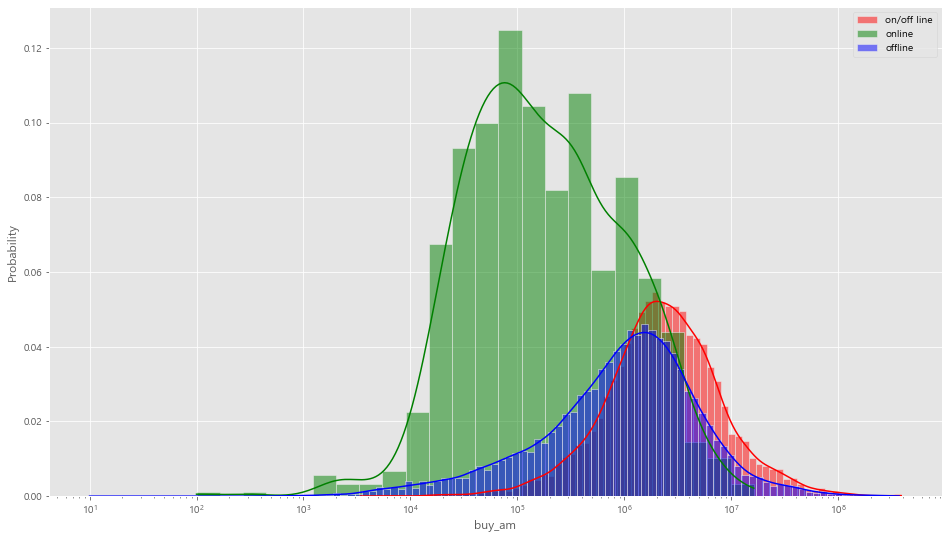

In [12]:
sns.histplot(result_onoff['buy_am'], log_scale=True, kde=True, color='red', alpha=0.5, stat='probability', label="on/off line")
sns.histplot(result_on['buy_am'], log_scale=True, kde=True, color='green', alpha=0.5, stat='probability', label="online")
sns.histplot(result_off['buy_am'], log_scale=True, kde=True, color='blue', alpha=0.5, stat='probability', label="offline")
plt.legend()
plt.show()

In [13]:
from scipy.stats import kstest
import numpy as np

test_stat = kstest(result_onoff['buy_am'], result_on['buy_am'])
test_stat

KstestResult(statistic=0.6291340872882777, pvalue=4.993783164763954e-13)

In [14]:
test_stat = kstest(result_off['buy_am'], result_on['buy_am'])
test_stat

KstestResult(statistic=0.423255355766612, pvalue=3.9097989861462917e-138)

In [15]:
test_stat = kstest(result_onoff['buy_am'], result_off['buy_am'])
test_stat

KstestResult(statistic=0.24175128392548173, pvalue=2.734697052427284e-296)

총 금액 사용량 ks test p-value가 0에 가까운 값이다. 즉 온라인, 오프라인, 온+오프라인인 경우 전부 다른 분포를 가진다고 할 수 있다. 그래프에서 확인 가능하다.

## loyal / unloyal

충성 고객, 비충성 고객 3을 기준으로 나누는 이유

In [16]:
result_royal = result[result["rct_no"]>3] #충성
result_unroyal = result[result["rct_no"]<=3] #비충성

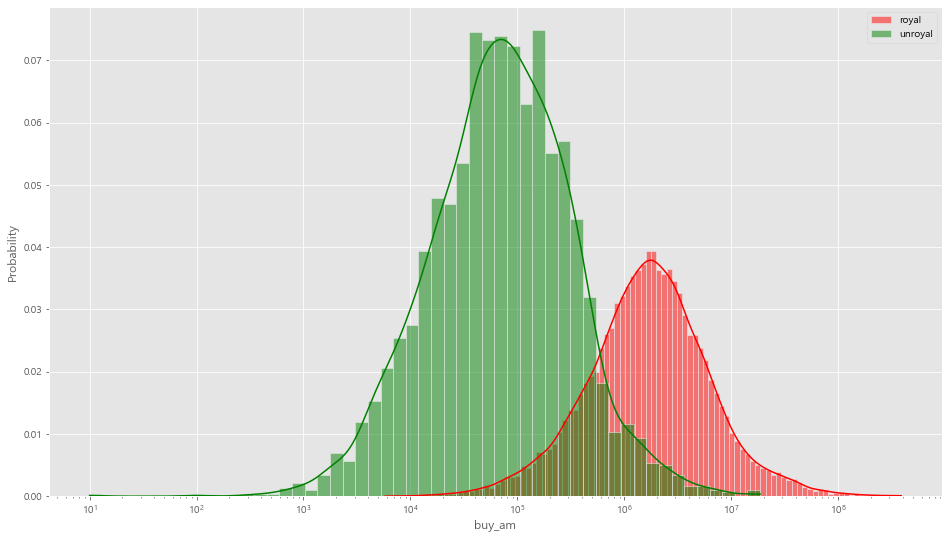

In [17]:
sns.histplot(result_royal['buy_am'], log_scale=True, kde=True, color='red', alpha=0.5, stat='probability', label="royal")
sns.histplot(result_unroyal['buy_am'], log_scale=True, kde=True, color='green', alpha=0.5, stat='probability', label="unroyal")
plt.legend()
plt.show()

In [18]:
test_stat = kstest(result_royal['buy_am'], result_unroyal['buy_am'])
test_stat

KstestResult(statistic=0.7651845793384544, pvalue=0.0)

충성 고객을 주로 구매횟수 3회를 기준으로 나눈다. (Domain지식), 총 금액 사용량 ks test 결과 다른 분포이다.

## vip / unvip

vip를 200,000을 기준으로 나누는 이유 (충성, 비충성 고객 분류보다 조금 더 구체화 하기 위해서)

In [19]:
result_vip = result[result["buy_am"]>200000] #vip
result_unvip = result[result["buy_am"]<=200000] #unvip

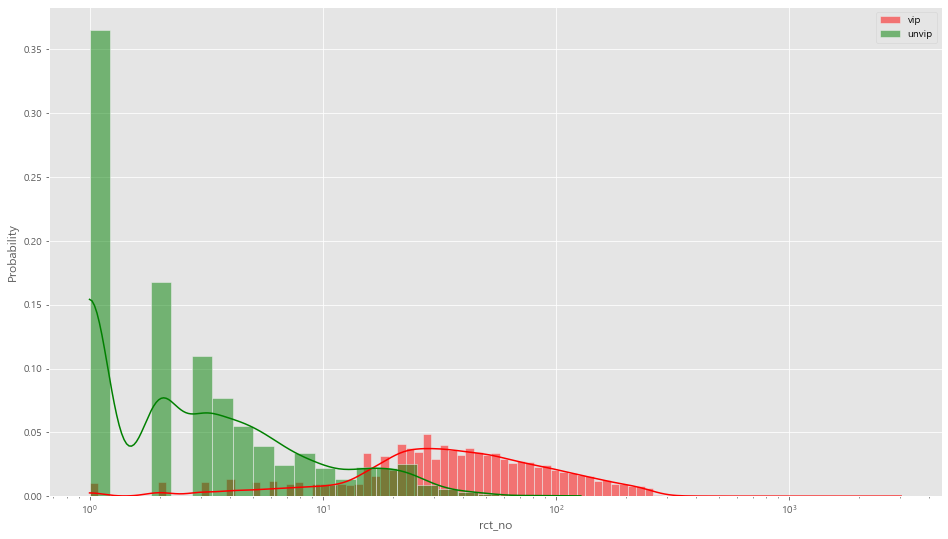

In [20]:
sns.histplot(result_vip['rct_no'], log_scale=True, kde=True, color='red', alpha=0.5, stat='probability', label="vip")
sns.histplot(result_unvip['rct_no'], log_scale=True, kde=True, color='green', alpha=0.5, stat='probability', label="unvip")
plt.legend()
plt.show()

In [21]:
test_stat = kstest(result_vip['rct_no'], result_unvip['rct_no'])
test_stat

KstestResult(statistic=0.777633306491582, pvalue=0.0)

**클러스터 해석**

0. 온라인만 사용하는 충성&vip 고객 
1. 온라인만 사용하는 충성&unvip 고객
2. 온라인만 사용하는 비충성 고객


3. 온라인, 오프라인 모두 사용하는 충성&vip 고객 
4. 온라인, 오프라인 모두 사용하는 충성&unvip 고객
5. 온라인, 오프라인 모두 사용하는 비충성 고객


6. 오프라인만 사용하는 충성&vip 고객 
7. 오프라인만 사용하는 충성&unvip 고객
8. 오프라인만 사용하는 비충성 고객

In [22]:
result['cluster'].value_counts()

6    13847
3     8239
8     2434
7     1170
2      574
0      287
5      185
4      152
1       29
Name: cluster, dtype: int64

In [23]:
result.head()

,cust,ma_fem_dv,ages,zon_hlv,chnl_dv,rct_no,buy_am,cluster
0,M001248380,여성,30대,Z10,2,38,992100.0,0
1,M006962764,남성,30대,Z17,2,35,1085730.0,0
2,M008864908,남성,30대,Z04,2,22,968700.0,0
3,M014792007,여성,30대,Z13,2,4,735200.0,0
4,M021341630,여성,40대,Z07,2,23,2718870.0,0


In [24]:
# 1 Cluster : 온라인만 사용하는 충성&unvip 고객
result.loc[result["cluster"]==1]

,cust,ma_fem_dv,ages,zon_hlv,chnl_dv,rct_no,buy_am,cluster
287,M023543251,여성,20대,Z16,2,6,105480.0,1
288,M063059486,남성,50대,Z04,2,4,55120.0,1
289,M114374841,여성,30대,Z10,2,4,158290.0,1
290,M120247124,남성,30대,Z17,2,20,197080.0,1
291,M156591412,남성,20대,Z11,2,4,154900.0,1
...,...,...,...,...,...,...,...,...
311,M867637042,남성,30대,Z10,2,5,153300.0,1
312,M873044482,여성,30대,Z11,2,5,178194.0,1
313,M912616576,남성,30대,Z17,2,4,156160.0,1
314,M935051519,여성,50대,Z12,2,17,43400.0,1


In [25]:
result.loc[result["cluster"]==6]

,cust,ma_fem_dv,ages,zon_hlv,chnl_dv,rct_no,buy_am,cluster
9466,M000034966,여성,40대,Z07,1,12,654120.0,6
9467,M000225114,여성,40대,Z17,1,78,1937700.0,6
9468,M000261625,여성,40대,Z17,1,48,6052700.0,6
9469,M000350564,여성,60대,Z10,1,29,9630400.0,6
9470,M000419293,여성,40대,Z17,1,39,1833500.0,6
...,...,...,...,...,...,...,...,...
23308,M999441814,여성,50대,Z08,1,5,282200.0,6
23309,M999468256,여성,70대,Z06,1,19,438960.0,6
23310,M999515910,남성,40대,Z05,1,33,7119795.0,6
23311,M999673157,남성,30대,Z10,1,17,2851370.0,6


# 적절한 파생변수란 무엇일까?
---

1. 고객의 특성을 가장 잘 나타내는 변수
    - 성별, 나이, 지역, 온/오프라인, 영수증 개수, 구매 금액 등?
    - 어떤 유통사에서 구매를 가장 많이 하는가?
    - 유통사별 이용 비율
    - 가장 많이 구매한 품목

## 1. On/Offline의 구분
---

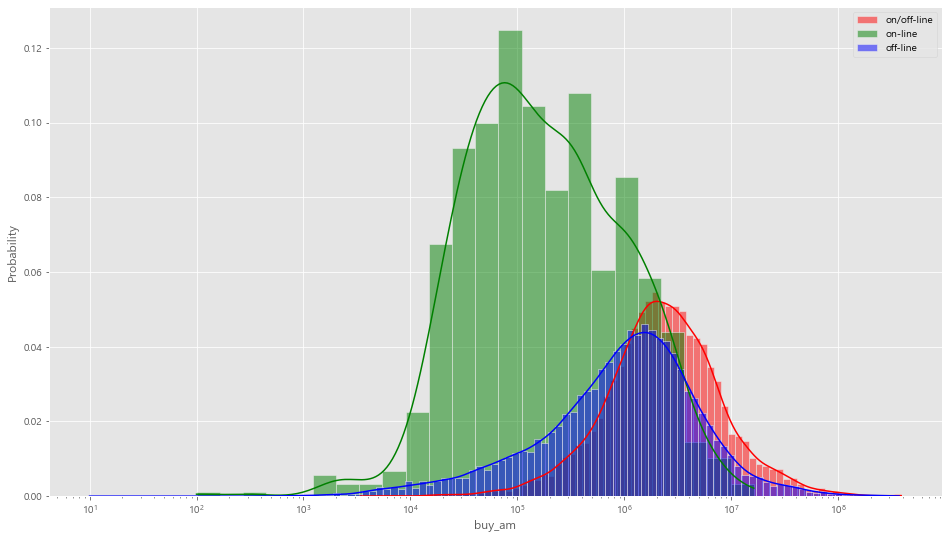

In [26]:
sns.histplot(result_onoff['buy_am'], log_scale=True, kde=True, color='red', alpha=0.5, stat='probability', label="on/off-line")
sns.histplot(result_on['buy_am'], log_scale=True, kde=True, color='green', alpha=0.5, stat='probability', label="on-line")
sns.histplot(result_off['buy_am'], log_scale=True, kde=True, color='blue', alpha=0.5, stat='probability', label="off-line")
plt.legend()
plt.show()

In [27]:
# -- 금액 비율
total = sum(result_onoff['buy_am'].values.tolist() + result_off['buy_am'].values.tolist() + result_on['buy_am'].values.tolist())
print(f"Ratio of ON-OFF : {sum(result_onoff['buy_am'])/total}")
print(f"Ratio of OFF : {result_off['buy_am'].sum()/total}")
print(f"Ratio of ON : {result_on['buy_am'].sum()/total}")

Ratio of ON-OFF : 0.445750927236878
Ratio of OFF : 0.5487245111756761
Ratio of ON : 0.005524561587445953


In [28]:
# -- 고객 비율
total = result["cust"].nunique()
print(f"Ratio of ON-OFF : {result_onoff['cust'].nunique()/total}")
print(f"Ratio of OFF : {result_off['cust'].nunique()/total}")
print(f"Ratio of ON : {result_on['cust'].nunique()/total}")

Ratio of ON-OFF : 0.31860905747297247
Ratio of OFF : 0.6483263365159565
Ratio of ON : 0.03306460601107107


In [29]:
result_off["cust"].nunique()

17451

In [30]:
df_onoff_cust = df_pdde.loc[df_pdde["cust"].isin(result_onoff["cust"].values.tolist())]


In [31]:
df_onoff_pivot = pd.pivot_table(data = df_onoff_cust,
               index="cust",
               columns="chnl_dv",
               values="rct_no",
               aggfunc="count")
df_onoff_pivot.reset_index(inplace=True)
df_onoff_pivot["sum_ch"] = df_onoff_pivot[1]+df_onoff_pivot[2]
df_onoff_pivot["ratio_off"] = df_onoff_pivot[1]/df_onoff_pivot["sum_ch"]
df_onoff_pivot["ratio_on"] = df_onoff_pivot[2]/df_onoff_pivot["sum_ch"]
df_onoff_pivot

chnl_dv,cust,1,2,sum_ch,ratio_off,ratio_on
0,M000136117,96,13,109,0.880734,0.119266
1,M000494848,334,63,397,0.841310,0.158690
2,M000621637,170,21,191,0.890052,0.109948
3,M000986912,69,27,96,0.718750,0.281250
4,M001332751,398,1,399,0.997494,0.002506
...,...,...,...,...,...,...
8571,M999105944,27,2,29,0.931034,0.068966
8572,M999180761,44,1,45,0.977778,0.022222
8573,M999599111,32,2,34,0.941176,0.058824
8574,M999770689,298,17,315,0.946032,0.053968


In [32]:
df_onoff_pivot.describe()

chnl_dv,1,2,sum_ch,ratio_off,ratio_on
count,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000
mean,183.091884,46.315065,229.406950,0.796903,0.203097
std,246.267315,102.291895,269.574151,0.260292,0.260292
min,1.000000,1.000000,2.000000,0.002755,0.000080
25%,44.000000,2.000000,64.000000,0.695471,0.018261
50%,110.000000,7.000000,148.000000,0.926606,0.073394
75%,244.000000,37.000000,313.000000,0.981739,0.304529
max,12447.000000,1748.000000,12448.000000,0.999920,0.997245


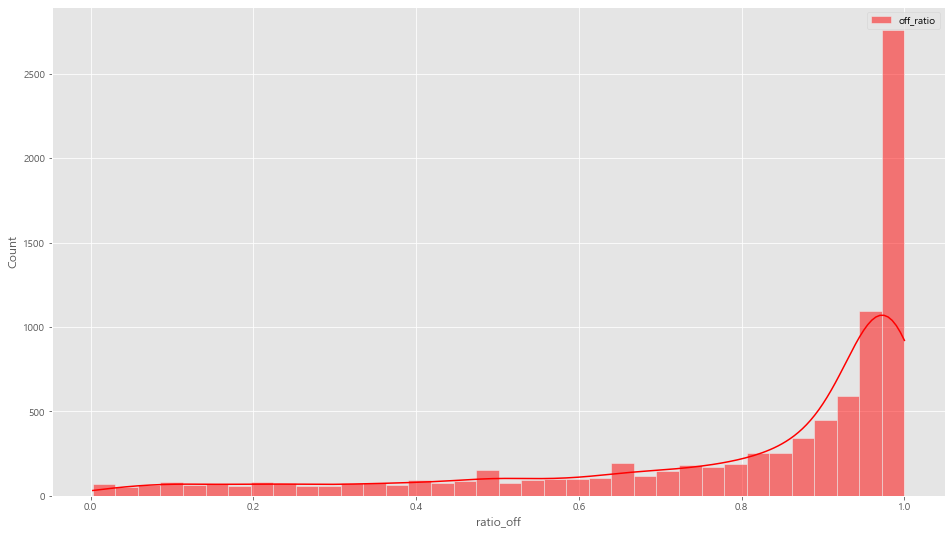

In [33]:
sns.histplot(df_onoff_pivot["ratio_off"], alpha=.5, color="red", kde=True, label="off_ratio")
#sns.histplot(df_onoff_pivot["ratio_on"], alpha=.5, color='green', kde=True, label="on_rartio")
plt.legend()
plt.show()

- on-off 사용 중 on 비중이 큰 사람이 적음

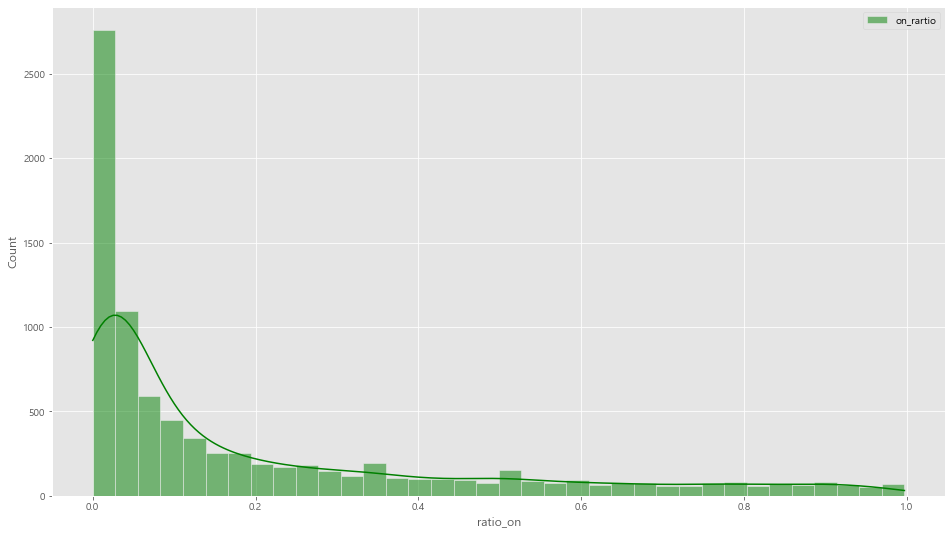

In [34]:
# sns.histplot(df_onoff_pivot["ratio_off"], alpha=.5, color="red", kde=True, label="off_ratio")
sns.histplot(df_onoff_pivot["ratio_on"], alpha=.5, color='green', kde=True, label="on_rartio")
plt.legend()
plt.show()

8월 5일

In [35]:
# 누락 데이터 삭제
def check_on_off(df_main, df, key="cust", col_nm="chnl_dv"):
    df_new = pd.DataFrame(df.groupby(key)[col_nm].apply(lambda x:list(set(x))))
    return df_main.merge(df_new, how="left", on=key).dropna(subset=["chnl_dv"])

# on/off 분류
def split_on_off(df, col_nm="chnl_dv"):
    df[col_nm] = df[col_nm].apply(lambda x: x[0] if len(x)==1 else 0)
    df_res1 = df.loc[df[col_nm]==1] ##off
    df_res2 = df.loc[df[col_nm]==2] ##on
    df_res3 = df.loc[df[col_nm]==0] ##onf
    return df_res1, df_res2, df_res3 #off, on, onf

# loyal/unloyal 분류
def split_loyal(df_main, df_sub, col_nm ='rct_no', key = 'cust'):
    df_rct_no = pd.DataFrame(df_sub.groupby([key])[col_nm].apply(lambda x: len(list(set(x))))).reset_index()
    df_m2 = df_main.merge(df_rct_no, how="left", on=key)
    df_loyal = df_m2.loc[df_m2[col_nm]>3]
    df_unloyal = df_m2.loc[df_m2[col_nm]<=3]
    return df_loyal, df_unloyal

# vip/unvip 분류
def split_vip(df_main, df_sub, col_nm='buy_am', key='cust'):
    df_buy_am = pd.DataFrame(df_sub.groupby([key],as_index=False)[col_nm].sum())
    df_m2 = df_main.merge(df_buy_am, how='left', on=key)
    df_vip = df_m2.loc[df_m2[col_nm]>200000]
    df_unvip = df_m2.loc[df_m2[col_nm]<=200000]
    return df_vip, df_unvip

##unloyal Nan 문제 해결
def unloyal_buy_am_solve(df_main, df_sub, col_nm='buy_am', key='cust'):
    df_buy_am = pd.DataFrame(df_sub.groupby([key],as_index=False)[col_nm].sum())
    df_m2 = df_main.merge(df_buy_am, how='left', on=key)
    return df_m2


def domain_clustering(df_main, df_sub):
    df = check_on_off(df_main, df_sub)

    df_off, df_on, df_onf = split_on_off(df)

    df_01, df_2 = split_loyal(df_on, df_sub)
    df_34, df_5 = split_loyal(df_onf, df_sub)
    df_67, df_8 = split_loyal(df_off, df_sub)

    df_0, df_1 = split_vip(df_01, df_sub)
    df_3, df_4 = split_vip(df_34, df_sub)
    df_6, df_7 = split_vip(df_67, df_sub)
    
    df_2 = unloyal_buy_am_solve(df_2, df_sub)
    df_5 = unloyal_buy_am_solve(df_5, df_sub)
    df_8 = unloyal_buy_am_solve(df_8, df_sub)
    
    df_init = pd.DataFrame()
    for i, df_temp in enumerate([df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8]):
        df_temp["cluster"] = i
        df_init = pd.concat([df_init, df_temp], axis=0, ignore_index=True)
        
    return df_init


In [36]:
result

,cust,ma_fem_dv,ages,zon_hlv,chnl_dv,rct_no,buy_am,cluster
0,M001248380,여성,30대,Z10,2,38,992100.0,0
1,M006962764,남성,30대,Z17,2,35,1085730.0,0
2,M008864908,남성,30대,Z04,2,22,968700.0,0
3,M014792007,여성,30대,Z13,2,4,735200.0,0
4,M021341630,여성,40대,Z07,2,23,2718870.0,0
...,...,...,...,...,...,...,...,...
26912,M996092967,여성,60대,Z16,1,3,349000.0,8
26913,M996679486,여성,40대,Z16,1,2,14180.0,8
26914,M997482914,여성,40대,Z03,1,2,64000.0,8
26915,M999340261,남성,50대,Z11,1,3,3468000.0,8


In [37]:
result['chnl_dv'].unique() #1 오프라인, 2 온라인, 0 온,오프라인

array([2, 0, 1], dtype=int64)

In [38]:
result_onoff = result[result['chnl_dv']==0]
result_off = result[result['chnl_dv']==1]
result_on = result[result['chnl_dv']==2]

In [39]:
result_not_off = pd.concat([result_onoff, result_on], axis=0, ignore_index=True)
result_not_off['off_or_not'] = 0 #not_off
result_not_off[['cust', 'off_or_not']].to_csv('result_not_off.csv', index=False)

result_off['off_or_not'] = 1 #off
result_off[['cust', 'off_or_not']].to_csv('result_off.csv', index=False)

C:\Users\LEECHO~1\AppData\Local\Temp/ipykernel_53748/3381531562.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_off['off_or_not'] = 1 #off


In [40]:
df_pdde_cop_u = df_pdde.merge(df_pd_clac, on='pd_c', how='left')
df_pdde_cop_u

,cust,rct_no,chnl_dv,cop_c,br_c,...,buy_am,buy_ct,pd_nm,clac_hlv_nm,clac_mcls_nm
0,M430112881,A01000001113,1,A01,A010039,...,15000.0,1,남성티셔츠,남성의류,남성의류상의
1,M646853852,A01000002265,1,A01,A010025,...,79700.0,1,기타주방일회용품,주방잡화,주방일회용품
2,M430112881,A01000003148,1,A01,A010039,...,19000.0,1,남성티셔츠,남성의류,남성의류상의
3,M430112881,A01000003148,1,A01,A010039,...,19000.0,1,남성티셔츠,남성의류,남성의류상의
4,M430112881,A01000004946,1,A01,A010039,...,19000.0,1,남성티셔츠,남성의류,남성의류상의
...,...,...,...,...,...,...,...,...,...,...,...
4381738,M533286446,E06052119978,2,A06,NaN,...,50000.0,1,백화점/마트모바일상품권,상품권,모바일상품권
4381739,M533286446,E06052119978,2,A06,NaN,...,50000.0,1,백화점/마트모바일상품권,상품권,모바일상품권
4381740,M533286446,E06052119978,2,A06,NaN,...,50000.0,1,백화점/마트모바일상품권,상품권,모바일상품권
4381741,M533286446,E06052119978,2,A06,NaN,...,50000.0,1,백화점/마트모바일상품권,상품권,모바일상품권


In [41]:

df_pdde_cop_u_pivot = pd.pivot_table(data = df_pdde_cop_u,
               index="cust",
               columns="cop_c",
               values="rct_no",
               aggfunc="count")
df_pdde_cop_u_pivot.reset_index(inplace=True)
df_pdde_cop_u_pivot.fillna(0, inplace=True)
df_pdde_cop_u_pivot

cop_c,cust,A01,A02,A03,A04,A05,A06
0,M000034966,4.0,44.0,0.0,3.0,0.0,0.0
1,M000136117,89.0,10.0,0.0,0.0,0.0,10.0
2,M000201112,0.0,0.0,0.0,21.0,0.0,0.0
3,M000225114,156.0,0.0,3.0,0.0,0.0,0.0
4,M000261625,67.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
26912,M999599111,1.0,28.0,0.0,4.0,0.0,1.0
26913,M999673157,12.0,0.0,0.0,12.0,0.0,0.0
26914,M999770689,22.0,120.0,24.0,149.0,0.0,0.0
26915,M999849895,24.0,43.0,0.0,5.0,0.0,0.0


In [42]:
result_off_not_off= pd.concat([result_off[['cust', 'off_or_not']], result_not_off[['cust', 'off_or_not']]], axis=0, ignore_index=False)
result_off_not_off

,cust,off_or_not
9466,M000034966,1
9467,M000225114,1
9468,M000261625,1
9469,M000350564,1
9470,M000419293,1
...,...,...
9461,M993876654,0
9462,M994285756,0
9463,M994550219,0
9464,M995528586,0


In [43]:
result_merged_off_or_not = result.merge(result_off_not_off, how='left', on='cust')
result_merged_off_or_not

,cust,ma_fem_dv,ages,zon_hlv,chnl_dv,rct_no,buy_am,cluster,off_or_not
0,M001248380,여성,30대,Z10,2,38,992100.0,0,0
1,M006962764,남성,30대,Z17,2,35,1085730.0,0,0
2,M008864908,남성,30대,Z04,2,22,968700.0,0,0
3,M014792007,여성,30대,Z13,2,4,735200.0,0,0
4,M021341630,여성,40대,Z07,2,23,2718870.0,0,0
...,...,...,...,...,...,...,...,...,...
26912,M996092967,여성,60대,Z16,1,3,349000.0,8,1
26913,M996679486,여성,40대,Z16,1,2,14180.0,8,1
26914,M997482914,여성,40대,Z03,1,2,64000.0,8,1
26915,M999340261,남성,50대,Z11,1,3,3468000.0,8,1


In [44]:
result_with_cop_u = result_merged_off_or_not.merge(df_pdde_cop_u_pivot, on='cust', how='left')
result_with_cop_u

,cust,ma_fem_dv,ages,zon_hlv,chnl_dv,...,A02,A03,A04,A05,A06
0,M001248380,여성,30대,Z10,2,...,0.0,0.0,0.0,0.0,38.0
1,M006962764,남성,30대,Z17,2,...,6.0,0.0,0.0,0.0,32.0
2,M008864908,남성,30대,Z04,2,...,0.0,0.0,0.0,0.0,22.0
3,M014792007,여성,30대,Z13,2,...,0.0,0.0,0.0,0.0,9.0
4,M021341630,여성,40대,Z07,2,...,532.0,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...
26912,M996092967,여성,60대,Z16,1,...,0.0,0.0,0.0,0.0,0.0
26913,M996679486,여성,40대,Z16,1,...,8.0,0.0,0.0,0.0,0.0
26914,M997482914,여성,40대,Z03,1,...,0.0,0.0,3.0,0.0,0.0
26915,M999340261,남성,50대,Z11,1,...,0.0,0.0,0.0,7.0,0.0


In [45]:
result_with_cop_u.columns

Index(['cust', 'ma_fem_dv', 'ages', 'zon_hlv', 'chnl_dv', 'rct_no', 'buy_am',
       'cluster', 'off_or_not', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06'],
      dtype='object')

In [46]:
temp_lst = [] 
for i in range(0,len(result_with_cop_u['cust'])):
    i_lst = [result_with_cop_u.loc[i, 'A01'], result_with_cop_u.loc[i, 'A02'], result_with_cop_u.loc[i, 'A03'], 
                result_with_cop_u.loc[i, 'A04'], result_with_cop_u.loc[i, 'A05'],result_with_cop_u.loc[i, 'A06']]
    i_lst_max_index = i_lst.index(max(i_lst))
    temp_lst.append(i_lst_max_index+1)


In [47]:
result_with_cop_u['max_cop_u'] = temp_lst
result_with_cop_u

,cust,ma_fem_dv,ages,zon_hlv,chnl_dv,...,A03,A04,A05,A06,max_cop_u
0,M001248380,여성,30대,Z10,2,...,0.0,0.0,0.0,38.0,6
1,M006962764,남성,30대,Z17,2,...,0.0,0.0,0.0,32.0,6
2,M008864908,남성,30대,Z04,2,...,0.0,0.0,0.0,22.0,6
3,M014792007,여성,30대,Z13,2,...,0.0,0.0,0.0,9.0,6
4,M021341630,여성,40대,Z07,2,...,0.0,0.0,0.0,4.0,2
...,...,...,...,...,...,...,...,...,...,...,...
26912,M996092967,여성,60대,Z16,1,...,0.0,0.0,0.0,0.0,1
26913,M996679486,여성,40대,Z16,1,...,0.0,0.0,0.0,0.0,2
26914,M997482914,여성,40대,Z03,1,...,0.0,3.0,0.0,0.0,4
26915,M999340261,남성,50대,Z11,1,...,0.0,0.0,7.0,0.0,5


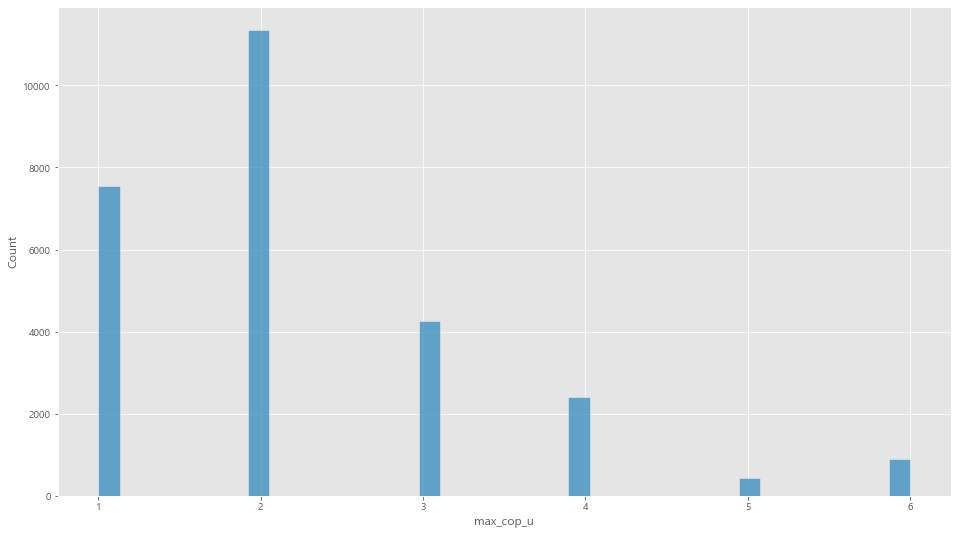

In [48]:
sns.histplot(result_with_cop_u['max_cop_u'])
plt.show()

DBSCAN 이상치 탐색 1

In [6]:
file_2_1 = pd.read_csv("../../LPOINT_BIG_COMP/2_1.csv")
file_2_2 = pd.read_csv("../../LPOINT_BIG_COMP/2_2.csv")


In [7]:
file_2_1.columns

Index(['cust', '가구', '건강식품', '건강용품', '건해산물', '계절가전', '공구/안전용품', '과일', '과자',
       '구기/필드스포츠', '금융/보험서비스', '기타(비상품)', '기타상품', '남성의류', '냉동식품', '냉장/세탁가전',
       '냉장식품', '담배', '대용식', '모바일', '문구/사무용품', '병통조림', '상품권', '생활/렌탈서비스',
       '생활/주방가전', '서적/음반/악기', '세제/위생', '속옷/양말/홈웨어', '수산물', '스포츠패션', '시즌스포츠',
       '식기/조리기구', '아웃도어/레저', '양곡', '여성의류', '여행/레저서비스', '영상/음향가전', '완구',
       '원예/애완', '유아동의류', '유아식품', '유제품', '음료', '인테리어/조명', '자동차용품', '조리식품',
       '조미료', '주류', '주방잡화', '채소', '청소/세탁/욕실용품', '축산물', '출산/육아용품', '침구/수예',
       '커피/차', '컴퓨터', '테넌트/음식점', '패션잡화', '퍼스널케어', '헬스/피트니스', '화장품/뷰티케어'],
      dtype='object')

In [8]:
file_2_2.columns

Index(['cust', '가구', '건강식품', '건강용품', '건해산물', '계절가전', '공구/안전용품', '과일', '과자',
       '구기/필드스포츠', '기타(비상품)', '기타상품', '남성의류', '냉동식품', '냉장/세탁가전', '냉장식품', '담배',
       '대용식', '모바일', '문구/사무용품', '병통조림', '상품권', '생활/렌탈서비스', '생활/주방가전',
       '서적/음반/악기', '세제/위생', '속옷/양말/홈웨어', '수산물', '스포츠패션', '시즌스포츠', '식기/조리기구',
       '아웃도어/레저', '양곡', '여성의류', '여행/레저서비스', '영상/음향가전', '완구', '원예/애완', '유아동의류',
       '유아식품', '유제품', '음료', '인테리어/조명', '자동차용품', '조리식품', '조미료', '주류', '주방잡화',
       '채소', '청소/세탁/욕실용품', '축산물', '출산/육아용품', '침구/수예', '커피/차', '컴퓨터', '테넌트/음식점',
       '패션잡화', '퍼스널케어', '헬스/피트니스', '화장품/뷰티케어'],
      dtype='object')

In [9]:
file_2_1_and_2 = pd.concat([file_2_1, file_2_2], axis=0, ignore_index=True)
file_2_1_and_2.fillna(0, inplace=True)

In [12]:
file_2_1_and_2

,cust,가구,건강식품,건강용품,건해산물,...,테넌트/음식점,패션잡화,퍼스널케어,헬스/피트니스,화장품/뷰티케어
0,M000136117,0.000000,0.000000,0.000000,0.000000,...,0.005967,0.013959,0.007725,0.015225,0.004961
1,M000494848,0.190139,0.360055,0.013548,0.000748,...,0.113725,0.002075,0.017131,0.000000,0.028460
2,M000621637,0.000000,0.000000,0.000000,0.000000,...,0.042942,0.006178,0.022578,0.000000,0.002247
3,M000986912,0.000000,0.000000,0.000000,0.000000,...,0.011205,0.000000,0.000544,0.000000,0.000000
4,M001086020,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
26912,M999468256,0.000000,0.000000,0.000000,0.000000,...,0.001208,0.000013,0.000754,0.000000,0.000514
26913,M999492154,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000
26914,M999515910,0.000000,0.000000,0.000000,0.004757,...,0.012378,0.000000,0.001545,0.000000,0.000011
26915,M999673157,0.000000,0.000000,0.000000,0.000000,...,0.000873,0.004577,0.000000,0.000000,0.000493


In [10]:
wnt_lst = list(file_2_1_and_2.columns)
wnt_lst.remove('cust')
wnt_lst

['가구',
 '건강식품',
 '건강용품',
 '건해산물',
 '계절가전',
 '공구/안전용품',
 '과일',
 '과자',
 '구기/필드스포츠',
 '금융/보험서비스',
 '기타(비상품)',
 '기타상품',
 '남성의류',
 '냉동식품',
 '냉장/세탁가전',
 '냉장식품',
 '담배',
 '대용식',
 '모바일',
 '문구/사무용품',
 '병통조림',
 '상품권',
 '생활/렌탈서비스',
 '생활/주방가전',
 '서적/음반/악기',
 '세제/위생',
 '속옷/양말/홈웨어',
 '수산물',
 '스포츠패션',
 '시즌스포츠',
 '식기/조리기구',
 '아웃도어/레저',
 '양곡',
 '여성의류',
 '여행/레저서비스',
 '영상/음향가전',
 '완구',
 '원예/애완',
 '유아동의류',
 '유아식품',
 '유제품',
 '음료',
 '인테리어/조명',
 '자동차용품',
 '조리식품',
 '조미료',
 '주류',
 '주방잡화',
 '채소',
 '청소/세탁/욕실용품',
 '축산물',
 '출산/육아용품',
 '침구/수예',
 '커피/차',
 '컴퓨터',
 '테넌트/음식점',
 '패션잡화',
 '퍼스널케어',
 '헬스/피트니스',
 '화장품/뷰티케어']

In [11]:
from scipy.spatial.distance import cdist

dist_map = cdist(file_2_1_and_2[wnt_lst], file_2_1_and_2[wnt_lst])

In [55]:
pd.DataFrame(dist_map, index=file_2_1_and_2["cust"], columns=file_2_1_and_2["cust"])

cust,M000136117,M000494848,M000621637,M000986912,M001086020,...,M999468256,M999492154,M999515910,M999673157,M999849895
cust,,,,,,,,,,,
M000136117,0.000000,0.504246,0.427145,0.303817,0.305411,...,0.303867,0.305345,0.518210,0.306935,0.309267
M000494848,0.504246,0.000000,0.543104,0.441982,0.446578,...,0.443856,0.446779,0.591430,0.446382,0.444874
M000621637,0.427145,0.543104,0.000000,0.346450,0.356310,...,0.355891,0.356315,0.489728,0.358014,0.354315
M000986912,0.303817,0.441982,0.346450,0.000000,0.028438,...,0.027950,0.025936,0.452441,0.049141,0.053849
M001086020,0.305411,0.446578,0.356310,0.028438,0.000000,...,0.029840,0.011589,0.458321,0.044717,0.055329
...,...,...,...,...,...,...,...,...,...,...,...
M999468256,0.303867,0.443856,0.355891,0.027950,0.029840,...,0.000000,0.028317,0.443545,0.047087,0.059717
M999492154,0.305345,0.446779,0.356315,0.025936,0.011589,...,0.028317,0.000000,0.460210,0.043108,0.055372
M999515910,0.518210,0.591430,0.489728,0.452441,0.458321,...,0.443545,0.460210,0.000000,0.448474,0.452624


In [56]:
eps_about_dist = np.quantile(dist_map, .10)
eps_about_dist

0.031244176258843695

In [57]:
from sklearn.cluster import DBSCAN
# eps_about_dist = 10
dbscan = DBSCAN(eps = 0.12, min_samples = 30, metric = "euclidean")
dbscan_labels = dbscan.fit_predict(file_2_1_and_2[wnt_lst])

In [58]:
np.unique(dbscan_labels, return_counts=True)

(array([-1,  0], dtype=int64), array([ 2473, 24444], dtype=int64))

In [59]:
file_2_1_and_2['DBSCAN_outlier'] = dbscan_labels
cust_DBSCAN_outlier_result = file_2_1_and_2[['cust', 'DBSCAN_outlier']]
cust_DBSCAN_outlier_result.to_csv('cust_and_DBSCAN_outlier.csv', index=False)

In [60]:
result_two_cluster = pd.concat([result_not_off, result_off], axis=0, ignore_index=True)
result_two_cluster

,cust,ma_fem_dv,ages,zon_hlv,chnl_dv,rct_no,buy_am,cluster,off_or_not
0,M000136117,여성,30대,Z11,0,70,27373630.0,3,0
1,M000494848,여성,30대,Z10,0,160,25624610.0,3,0
2,M000621637,여성,40대,Z11,0,137,16702330.0,3,0
3,M000986912,여성,30대,Z10,0,48,777430.0,3,0
4,M001332751,여성,30대,Z06,0,33,2814069.0,3,0
...,...,...,...,...,...,...,...,...,...
26912,M996092967,여성,60대,Z16,1,3,349000.0,8,1
26913,M996679486,여성,40대,Z16,1,2,14180.0,8,1
26914,M997482914,여성,40대,Z03,1,2,64000.0,8,1
26915,M999340261,남성,50대,Z11,1,3,3468000.0,8,1


In [61]:
result_two_cluster_and_DBSCAN_outlier = result_two_cluster.merge(cust_DBSCAN_outlier_result, how='left', on='cust')
result_two_cluster_and_DBSCAN_outlier = result_two_cluster_and_DBSCAN_outlier[['cust', 'off_or_not', 'DBSCAN_outlier']]
result_two_cluster_and_DBSCAN_outlier

,cust,off_or_not,DBSCAN_outlier
0,M000136117,0,-1
1,M000494848,0,-1
2,M000621637,0,-1
3,M000986912,0,0
4,M001332751,0,0
...,...,...,...
26912,M996092967,1,0
26913,M996679486,1,0
26914,M997482914,1,0
26915,M999340261,1,0


In [62]:
off_out_1 = result_two_cluster_and_DBSCAN_outlier[result_two_cluster_and_DBSCAN_outlier['DBSCAN_outlier']==0][result_two_cluster_and_DBSCAN_outlier['off_or_not']==0]
off_out_2 = result_two_cluster_and_DBSCAN_outlier[result_two_cluster_and_DBSCAN_outlier['DBSCAN_outlier']==0][result_two_cluster_and_DBSCAN_outlier['off_or_not']==1]

C:\Users\LEECHO~1\AppData\Local\Temp/ipykernel_53748/3255148417.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  off_out_1 = result_two_cluster_and_DBSCAN_outlier[result_two_cluster_and_DBSCAN_outlier['DBSCAN_outlier']==0][result_two_cluster_and_DBSCAN_outlier['off_or_not']==0]
C:\Users\LEECHO~1\AppData\Local\Temp/ipykernel_53748/3255148417.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  off_out_2 = result_two_cluster_and_DBSCAN_outlier[result_two_cluster_and_DBSCAN_outlier['DBSCAN_outlier']==0][result_two_cluster_and_DBSCAN_outlier['off_or_not']==1]


In [63]:
off_out_1

,cust,off_or_not,DBSCAN_outlier
3,M000986912,0,0
4,M001332751,0,0
5,M001353506,0,0
6,M001405587,0,0
7,M001444118,0,0
...,...,...,...
9461,M993876654,0,0
9462,M994285756,0,0
9463,M994550219,0,0
9464,M995528586,0,0


In [64]:
off_out_1.to_csv('off_out_1.csv', index=False)
off_out_2.to_csv('off_out_2.csv', index=False)


DBSCAN 이상치 탐색 1

In [65]:
file_2_1 = pd.read_csv("../../LPOINT_BIG_COMP/2_1.csv")
file_2_2 = pd.read_csv("../../LPOINT_BIG_COMP/2_2.csv")


In [66]:
file_2_1
file_2_2

,cust,가구,건강식품,건강용품,건해산물,...,테넌트/음식점,패션잡화,퍼스널케어,헬스/피트니스,화장품/뷰티케어
0,M000034966,0.000000,0.000000,0.000000,0.001071,...,0.000000,0.000000,0.000000,0.0,0.000000
1,M000201112,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000
2,M000225114,0.000000,0.000000,0.000000,0.000000,...,0.012579,0.000914,0.000000,0.0,0.001373
3,M000261625,0.000000,0.000000,0.000000,0.000000,...,0.044248,0.000076,0.018588,0.0,0.012273
4,M000350564,0.000307,0.017852,0.000000,0.000000,...,0.001342,0.008809,0.000000,0.0,0.002372
...,...,...,...,...,...,...,...,...,...,...,...
17446,M999468256,0.000000,0.000000,0.000000,0.000000,...,0.001208,0.000013,0.000754,0.0,0.000514
17447,M999492154,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000
17448,M999515910,0.000000,0.000000,0.000000,0.004757,...,0.012378,0.000000,0.001545,0.0,0.000011
17449,M999673157,0.000000,0.000000,0.000000,0.000000,...,0.000873,0.004577,0.000000,0.0,0.000493


In [67]:
wnt_lst_1 = list(file_2_1.columns)
wnt_lst_1.remove('cust')
print(len(wnt_lst_1))

wnt_lst_2 = list(file_2_2.columns)
wnt_lst_2.remove('cust')
print(len(wnt_lst_2))

60
59


In [68]:
from scipy.spatial.distance import cdist

dist_map_1 = cdist(file_2_1[wnt_lst_1], file_2_1[wnt_lst_1])
dist_map_2 = cdist(file_2_2[wnt_lst_2], file_2_2[wnt_lst_2])

In [69]:
pd.DataFrame(dist_map_1, index=file_2_1["cust"], columns=file_2_1["cust"])
pd.DataFrame(dist_map_2, index=file_2_2["cust"], columns=file_2_2["cust"])

cust,M000034966,M000201112,M000225114,M000261625,M000350564,...,M999468256,M999492154,M999515910,M999673157,M999849895
cust,,,,,,,,,,,
M000034966,0.000000,0.031657,0.067102,0.128936,0.083161,...,0.038146,0.031928,0.453811,0.051521,0.055922
M000201112,0.031657,0.000000,0.066673,0.129428,0.076803,...,0.028235,0.004628,0.458319,0.042604,0.054664
M000225114,0.067102,0.066673,0.000000,0.140463,0.103051,...,0.070043,0.068800,0.443164,0.068876,0.072693
M000261625,0.128936,0.129428,0.140463,0.000000,0.149767,...,0.131830,0.129449,0.474590,0.135331,0.136439
M000350564,0.083161,0.076803,0.103051,0.149767,0.000000,...,0.082455,0.078640,0.452693,0.089055,0.095299
...,...,...,...,...,...,...,...,...,...,...,...
M999468256,0.038146,0.028235,0.070043,0.131830,0.082455,...,0.000000,0.028317,0.443545,0.047087,0.059717
M999492154,0.031928,0.004628,0.068800,0.129449,0.078640,...,0.028317,0.000000,0.460210,0.043108,0.055372
M999515910,0.453811,0.458319,0.443164,0.474590,0.452693,...,0.443545,0.460210,0.000000,0.448474,0.452624


In [70]:
eps_about_dist_1 = np.quantile(dist_map_1, .10)
print(eps_about_dist_1)
eps_about_dist_2 = np.quantile(dist_map_2, .10)
print(eps_about_dist_2)

0.04941492192402783
0.024373384598670497


In [71]:

dbscan_1 = DBSCAN(eps = 0.12, min_samples = 30, metric = "euclidean")
dbscan_labels_1 = dbscan_1.fit_predict(file_2_1[wnt_lst_1])


dbscan_2 = DBSCAN(eps = 0.12, min_samples = 30, metric = "euclidean")
dbscan_labels_2 = dbscan_2.fit_predict(file_2_2[wnt_lst_2])

In [72]:
np.unique(dbscan_labels_1, return_counts=True)

(array([-1,  0], dtype=int64), array([1455, 8011], dtype=int64))

In [73]:
np.unique(dbscan_labels_2, return_counts=True)

(array([-1,  0], dtype=int64), array([ 1169, 16282], dtype=int64))

In [74]:
file_2_1['DBSCAN_outlier'] = dbscan_labels_1
file_2_2['DBSCAN_outlier'] = dbscan_labels_2

In [75]:
wnt_file_2_1 = pd.concat([file_2_1, file_2_2], axis=0, ignore_index=True)
wnt_file_2_1

,cust,가구,건강식품,건강용품,건해산물,...,패션잡화,퍼스널케어,헬스/피트니스,화장품/뷰티케어,DBSCAN_outlier
0,M000136117,0.000000,0.000000,0.000000,0.000000,...,0.013959,0.007725,0.015225,0.004961,-1
1,M000494848,0.190139,0.360055,0.013548,0.000748,...,0.002075,0.017131,0.000000,0.028460,-1
2,M000621637,0.000000,0.000000,0.000000,0.000000,...,0.006178,0.022578,0.000000,0.002247,-1
3,M000986912,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000544,0.000000,0.000000,0
4,M001086020,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...
26912,M999468256,0.000000,0.000000,0.000000,0.000000,...,0.000013,0.000754,0.000000,0.000514,0
26913,M999492154,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0
26914,M999515910,0.000000,0.000000,0.000000,0.004757,...,0.000000,0.001545,0.000000,0.000011,-1
26915,M999673157,0.000000,0.000000,0.000000,0.000000,...,0.004577,0.000000,0.000000,0.000493,0


In [76]:
result_noo = pd.concat([result_not_off,result_off], axis=0, ignore_index=True)
result_noo

,cust,ma_fem_dv,ages,zon_hlv,chnl_dv,rct_no,buy_am,cluster,off_or_not
0,M000136117,여성,30대,Z11,0,70,27373630.0,3,0
1,M000494848,여성,30대,Z10,0,160,25624610.0,3,0
2,M000621637,여성,40대,Z11,0,137,16702330.0,3,0
3,M000986912,여성,30대,Z10,0,48,777430.0,3,0
4,M001332751,여성,30대,Z06,0,33,2814069.0,3,0
...,...,...,...,...,...,...,...,...,...
26912,M996092967,여성,60대,Z16,1,3,349000.0,8,1
26913,M996679486,여성,40대,Z16,1,2,14180.0,8,1
26914,M997482914,여성,40대,Z03,1,2,64000.0,8,1
26915,M999340261,남성,50대,Z11,1,3,3468000.0,8,1


In [77]:
wntwnt = wnt_file_2_1[['cust','DBSCAN_outlier']].merge(result_noo, how='left', on="cust")
wntwnt[wntwnt['DBSCAN_outlier']==0][['cust', 'DBSCAN_outlier', 'off_or_not']].to_csv("out_off_34.csv", index=False)

8개로 나누기 도메인 클러스터링(2x4)

In [78]:
from sklearn.cluster import DBSCAN
# eps_about_dist = 10
dbscan = DBSCAN(eps = 0.12, min_samples = 30, metric = "euclidean")
dbscan_labels = dbscan.fit_predict(file_2_1_and_2[wnt_lst])

In [79]:
aaa =check_on_off(df_cust, df_pdde)
aaa

,cust,ma_fem_dv,ages,zon_hlv,chnl_dv
0,M000034966,여성,40대,Z07,[1]
2,M000136117,여성,30대,Z11,"[1, 2]"
3,M000201112,여성,50대,Z17,[1]
4,M000225114,여성,40대,Z17,[1]
5,M000261625,여성,40대,Z17,[1]
...,...,...,...,...,...
29906,M999599111,여성,40대,Z04,"[1, 2]"
29907,M999673157,남성,30대,Z10,[1]
29909,M999770689,여성,30대,Z16,"[1, 2]"
29910,M999849895,여성,20대,Z04,[1]


In [80]:
# 누락 데이터 삭제
def check_on_off(df_main, df, key="cust", col_nm="chnl_dv"):
    df_new = pd.DataFrame(df.groupby(key)[col_nm].apply(lambda x:list(set(x))))
    return df_main.merge(df_new, how="left", on=key).dropna(subset=["chnl_dv"])


def del_outlier_DBSCAN(df_main)

# on/off 분류
def split_on_off(df, col_nm="chnl_dv"):
    df[col_nm] = df[col_nm].apply(lambda x: x[0] if len(x)==1 else 0)
    df_off = df.loc[df[col_nm]==1] ##off
    df_on = df.loc[df[col_nm]==2] ##on
    df_onf = df.loc[df[col_nm]==0] ##onf

    df_not_off = pd.concat([df_on, df_onf], axis=0, ignore_index=True)


    return df_off, df_not_off #off, not_off

def classification_buy_am(x, std_points):
    if x <= std_points[0]:
        return "D"
    elif std_points[0] < x <= std_points[1]:
        return "C"
    elif std_points[1] < x <= std_points[2]:
        return "B"
    else:
        return "A"

def split_buy_amount_by_4(df_main, df_sub, key='cust', col_nm='buy_am'):
    df_new = df_sub.groupby([key], as_index=False)[col_nm].sum()
    df_new2 = df_main.merge(df_new, on='cust', how='left')
    df_new2["am_class"] = df_new2[col_nm].apply(classification_buy_am, std_points=np.quantile(df_new2[col_nm], [.25, .5, .75]))
    

    df_A = df_new2[df_new2['am_class']=='A']
    df_B = df_new2[df_new2['am_class']=='B']
    df_C = df_new2[df_new2['am_class']=='C']
    df_D = df_new2[df_new2['am_class']=='D']
    
    return df_A, df_B, df_C, df_D
    

def domain_clustering_ver2(df_main, df_sub):
    df = check_on_off(df_main, df_sub)

    df_off, df_not_off= split_on_off(df)

    
    df_off_A, df_off_B, df_off_C, df_off_D  = split_buy_amount_by_4(df_off, df_sub)
    df_not_off_A, df_not_off_B, df_not_off_C, df_not_off_D  = split_buy_amount_by_4(df_not_off, df_sub)

    df_off_A['cluster'] = 0
    df_off_B['cluster'] = 1
    df_off_C['cluster'] = 2
    df_off_D['cluster'] = 3
    df_not_off_A['cluster'] = 4
    df_not_off_B['cluster'] = 5
    df_not_off_C['cluster'] = 6
    df_not_off_D['cluster'] = 7

    df_off_A_label = df_off_A[['cust', 'cluster']]
    df_off_B_label = df_off_B[['cust', 'cluster']]
    df_off_C_label = df_off_C[['cust', 'cluster']]
    df_off_D_label = df_off_D[['cust', 'cluster']]
    df_not_off_A_label = df_not_off_A[['cust', 'cluster']]
    df_not_off_B_label = df_not_off_B[['cust', 'cluster']]
    df_not_off_C_label = df_not_off_C[['cust', 'cluster']]
    df_not_off_D_label = df_not_off_D[['cust', 'cluster']]
    

        
    return df_off_A_label, df_off_B_label, df_off_C_label, df_off_D_label, df_not_off_A_label, df_not_off_B_label, df_not_off_C_label, df_not_off_D_label


df_off_A_label, df_off_B_label, df_off_C_label, df_off_D_label, df_not_off_A_label, df_not_off_B_label, df_not_off_C_label, df_not_off_D_label = domain_clustering_ver2(df_cust, df_pdde) 

SyntaxError: invalid syntax (Temp/ipykernel_53748/340875586.py, line 7)

In [ ]:
df_label_result = pd.concat([df_off_A_label, df_off_B_label, df_off_C_label, df_off_D_label, 
df_not_off_A_label, df_not_off_B_label, df_not_off_C_label, df_not_off_D_label], axis=0, ignore_index=True)


In [ ]:
df_label_result

,cust,cluster
0,M000261625,0
1,M000350564,0
2,M001694463,0
3,M001697472,0
4,M001729158,0
...,...,...
26912,M997082506,7
26913,M998129365,7
26914,M998600186,7
26915,M999105944,7


In [ ]:
df_pdde_pd_clac = df_pdde.merge(df_pd_clac, how='left', on='pd_c')

In [ ]:
df_pt = pd.pivot_table(data=df_pdde_pd_clac,
               values='buy_am',
               index='cust',
               columns='clac_hlv_nm',
               aggfunc='sum',
               fill_value=0)



df_pt.reset_index(inplace=True)
df_pt_2 = df_pt #.iloc[:,1:]
df_pt_2

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(df_pt_2)
df_spt = pd.DataFrame(scaler.transform(df_pt_2), index=df_pt_2.index, columns=df_pt_2.columns)
df_spt

from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps = 0.12, min_samples = 30, metric = "euclidean")
dbscan_labels = dbscan.fit_predict(df_pt_2)
np.unique(dbscan_labels, return_counts=True)



clac_hlv_nm,cust,가구,건강식품,건강용품,건해산물,...,테넌트/음식점,패션잡화,퍼스널케어,헬스/피트니스,화장품/뷰티케어
0,M000034966,0,0,0,6960,...,0,0,0,0,0
1,M000136117,0,0,0,0,...,27000,4997600,56800,154000,209000
2,M000201112,0,0,0,0,...,0,0,0,0,0
3,M000225114,0,0,0,0,...,93700,334000,0,0,323000
4,M000261625,0,0,0,0,...,329600,27800,503000,0,2887000
...,...,...,...,...,...,...,...,...,...,...,...
26912,M999599111,0,17900,0,9980,...,0,0,0,0,0
26913,M999673157,0,0,0,0,...,6500,1673000,0,0,116000
26914,M999770689,0,108300,43000,0,...,69390,28500,0,0,0
26915,M999849895,0,0,7400,0,...,60800,41800,0,0,0


In [ ]:
df_pdde_pd_clac

,cust,rct_no,chnl_dv,cop_c,br_c,...,buy_am,buy_ct,pd_nm,clac_hlv_nm,clac_mcls_nm
0,M430112881,A01000001113,1,A01,A010039,...,15000.0,1,남성티셔츠,남성의류,남성의류상의
1,M646853852,A01000002265,1,A01,A010025,...,79700.0,1,기타주방일회용품,주방잡화,주방일회용품
2,M430112881,A01000003148,1,A01,A010039,...,19000.0,1,남성티셔츠,남성의류,남성의류상의
3,M430112881,A01000003148,1,A01,A010039,...,19000.0,1,남성티셔츠,남성의류,남성의류상의
4,M430112881,A01000004946,1,A01,A010039,...,19000.0,1,남성티셔츠,남성의류,남성의류상의
...,...,...,...,...,...,...,...,...,...,...,...
4381738,M533286446,E06052119978,2,A06,NaN,...,50000.0,1,백화점/마트모바일상품권,상품권,모바일상품권
4381739,M533286446,E06052119978,2,A06,NaN,...,50000.0,1,백화점/마트모바일상품권,상품권,모바일상품권
4381740,M533286446,E06052119978,2,A06,NaN,...,50000.0,1,백화점/마트모바일상품권,상품권,모바일상품권
4381741,M533286446,E06052119978,2,A06,NaN,...,50000.0,1,백화점/마트모바일상품권,상품권,모바일상품권


clac_hlv_nm,가구,건강식품,건강용품,건해산물,계절가전,...,테넌트/음식점,패션잡화,퍼스널케어,헬스/피트니스,화장품/뷰티케어
0,0.0,0.000000,0.000000,0.000813,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.000000,0.000000,0.000000,0.0,...,0.003625,0.013671,0.002099,0.015225,0.000888
2,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.000000,0.000000,0.000000,0.0,...,0.012579,0.000914,0.000000,0.000000,0.001373
4,0.0,0.000000,0.000000,0.000000,0.0,...,0.044248,0.000076,0.018588,0.000000,0.012273
...,...,...,...,...,...,...,...,...,...,...,...
26912,0.0,0.001076,0.000000,0.001166,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000
26913,0.0,0.000000,0.000000,0.000000,0.0,...,0.000873,0.004577,0.000000,0.000000,0.000493
26914,0.0,0.006508,0.001428,0.000000,0.0,...,0.009315,0.000078,0.000000,0.000000,0.000000
26915,0.0,0.000000,0.000246,0.000000,0.0,...,0.008162,0.000114,0.000000,0.000000,0.000000
